In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
import zipfile

def unzip_files(directory_path, extract_to_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.zip'):
            zip_file_path = os.path.join(directory_path, filename)
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to_path)

main_directory = '/kaggle/input/dogs-vs-cats-redux-kernels-edition'
extract_to_path = '/kaggle/working/'

unzip_files(main_directory, extract_to_path)


In [3]:
import glob
import matplotlib.pyplot as plt
import cv2
import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers
import tensorflow as tf
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras import optimizers
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.activations import sigmoid
from keras.applications import ResNetRS420
import tensorflow as tf
from keras.layers import Dense,Flatten,Dropout,BatchNormalization
from keras.applications import DenseNet121,DenseNet169,DenseNet201,RegNetY320,RegNetX320

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Model Training:

In [4]:
train_dir= '/kaggle/working/train'
train_data=glob.glob(train_dir+'**/*.jpg',root_dir=train_dir)
train_data=train_data[:5000]

In [5]:
X_train=[]

for img_path in train_data:
    img= cv2.imread(img_path)
    img= cv2.resize(img,(256,256))
    img= img/255
    
    X_train.append(img)
    
X_train= np.array(X_train)

In [6]:
X_train.shape

(5000, 256, 256, 3)

In [7]:
files_name= glob.glob('*.jpg',root_dir= train_dir)
files_name[:5]

['cat.10331.jpg',
 'cat.11735.jpg',
 'cat.11419.jpg',
 'cat.10737.jpg',
 'cat.10998.jpg']

In [8]:
y_train = [file_name.split('.')[0] for file_name in files_name]

In [9]:
y_train = np.array(y_train)
y_train[:5]

array(['cat', 'cat', 'cat', 'cat', 'cat'], dtype='<U3')

In [10]:
y_train= y_train[:5000]

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
y_train= encoder.fit_transform(y_train)

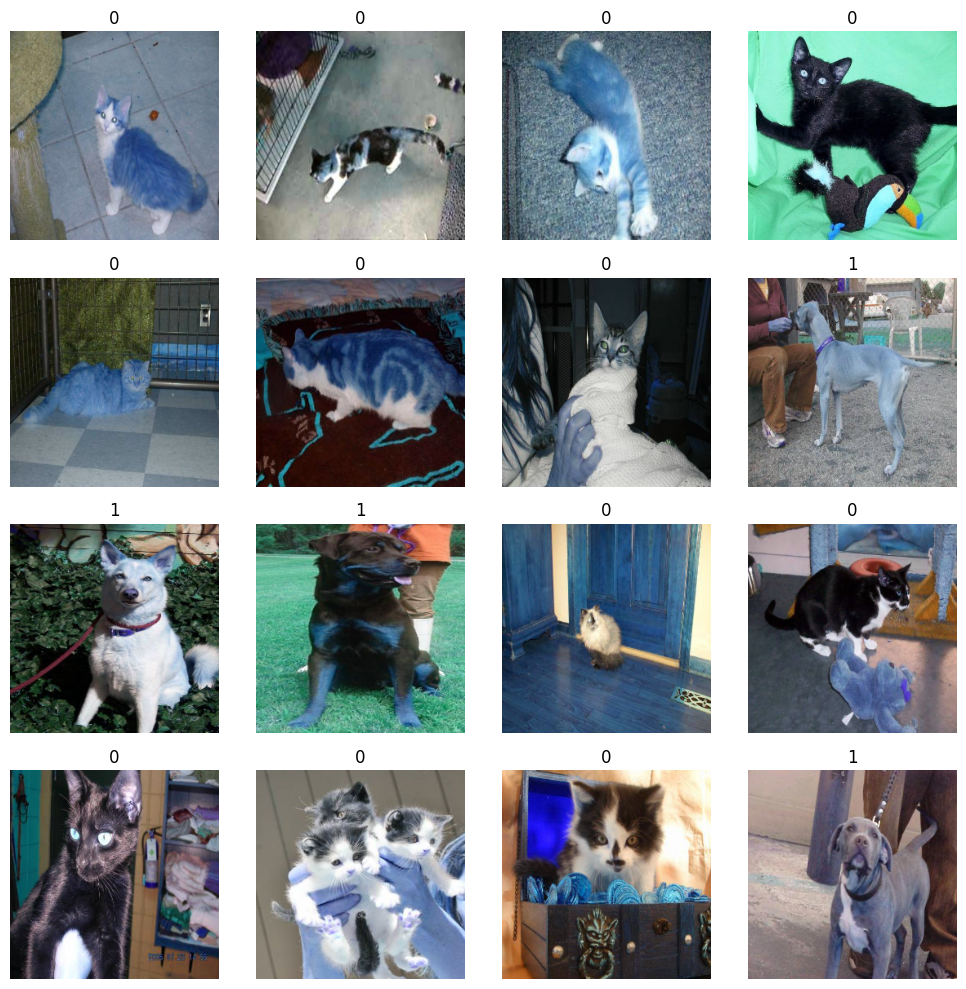

In [12]:
plt.figure(figsize=(10,10))
for i in range(min(16, len(X_train))):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:


base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    BatchNormalization(),
    
    Flatten(),
    
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 batch_normalization (Batch  (None, 8, 8, 1920)        7680      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 122880)            0         
                                                                 
 dense (Dense)               (None, 256)               31457536  
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [15]:
# Learning rate schedule
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=2000,
    decay_rate=0.7
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
125/125 [==============================] - 45s 193ms/step - loss: 0.2148 - accuracy: 0.9180 - val_loss: 0.0791 - val_accuracy: 0.9830
Epoch 2/30
125/125 [==============================] - 17s 137ms/step - loss: 0.0740 - accuracy: 0.9850 - val_loss: 0.0486 - val_accuracy: 0.9880
Epoch 3/30
125/125 [==============================] - 17s 136ms/step - loss: 0.0503 - accuracy: 0.9898 - val_loss: 0.0405 - val_accuracy: 0.9890
Epoch 4/30
125/125 [==============================] - 17s 137ms/step - loss: 0.0330 - accuracy: 0.9952 - val_loss: 0.0347 - val_accuracy: 0.9900
Epoch 5/30
125/125 [==============================] - 17s 136ms/step - loss: 0.0269 - accuracy: 0.9975 - val_loss: 0.0324 - val_accuracy: 0.9870
Epoch 6/30
125/125 [==============================] - 17s 136ms/step - loss: 0.0204 - accuracy: 0.9977 - val_loss: 0.0299 - val_accuracy: 0.9890
Epoch 7/30
125/125 [==============================] - 17s 136ms/step - loss: 0.0184 - accuracy: 0.9985 - val_loss: 0.0273 - val_ac

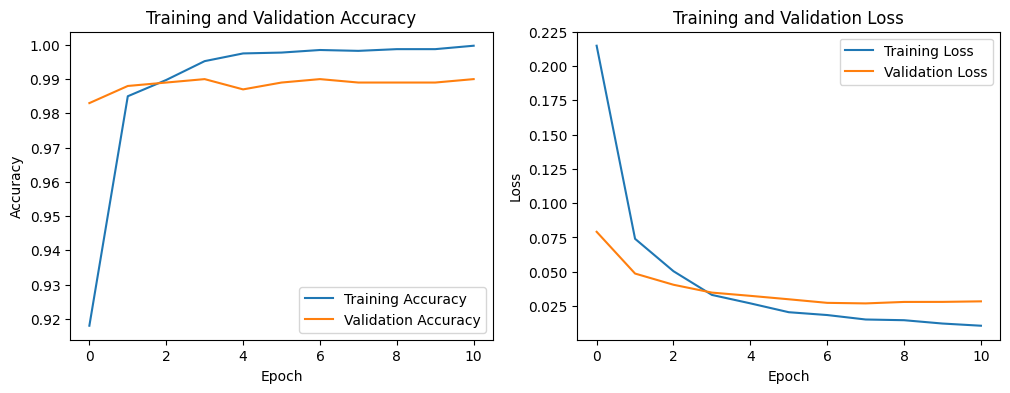

In [17]:

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [18]:
model.save('catvsdog.keras')

# Model Testing:

In [19]:
from keras.models import load_model

model= load_model('/kaggle/working/catvsdog.keras')

In [20]:
test_dir= '/kaggle/working/test'

In [21]:
test_data=glob.glob(test_dir+'/*.jpg')

In [22]:
# X_test=[]

# for img_path in test_data:
#     img= cv2.imread(img_path)
#     img= cv2.resize(img,(256,256))
#     img= img/255
    
#     X_test.append(img)
    
# X_test= np.array(X_test)

In [23]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import cv2

# Define a function to preprocess images
def preprocess_image(img):
    img = cv2.resize(img, (256, 256))
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    return img

# Example of batch processing
batch_size = 32

# Initialize an empty list to store predictions
all_predictions = []

for i in range(0, len(test_data), batch_size):
    batch_paths = test_data[i:i + batch_size]
    batch_images = [cv2.imread(img_path) for img_path in batch_paths]
    batch_images = [preprocess_image(img) for img in batch_images]

    # Convert the batch to a numpy array
    batch_data = np.vstack(batch_images)

    # Predictions for the current batch
    predictions = model.predict(batch_data)

    # Extend the predictions list
    all_predictions.extend(predictions.flatten())

# Now, 'all_predictions' contains predictions for all test images
all_predictions = np.array(all_predictions)


1/1 [==============================] - 6s 6s/step


In [24]:
# Create a new DataFrame with 'label' column
submission_df = pd.DataFrame({'label': all_predictions})

# Save the new DataFrame to a CSV file
submission_df.to_csv('/kaggle/working/new_submission.csv', index=False)